Две необходимых ссылки
https://pysindy.readthedocs.io/en/latest/examples/index.html

https://pysindy.readthedocs.io/en/latest/examples/2_introduction_to_sindy/example.html

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import random

from scipy.integrate import solve_ivp
import torch 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import pysindy as ps

# Генерация данных как в CRNN-модели

### Функция для вычисления приращений концентраций веществ

In [3]:
def true_ode_func(t: float, y: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : np.array
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : np.array
        Константы скоростей реакций (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    
    dydt = np.empty_like(y)                          # можно использовать np.zeros_like(y), но это быстрее
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

### Константы

In [4]:
N_REACTION = 4                                                       # кол-во реакций
N_SUBSTANCE = 5                                                      # кол-во веществ
VR_TIME = 30                                                         # время протекания реакций
INIT_CONC = np.array([1.8, 1.5, 1.1, 1, 1])                          # начальные концентрации веществ
k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)         # константы скоростей реакций

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(tspan[0], tspan[1], VR_TIME*2 + 1)                # шаги по временному промежутку (количество точек)

# Стехиометрическая матрица (матрица реакций) в базовом виде
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

In [5]:
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
print(MATR_PLUS)

[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]]


### Вычисление и визуализация изменения концентраций веществ со временем

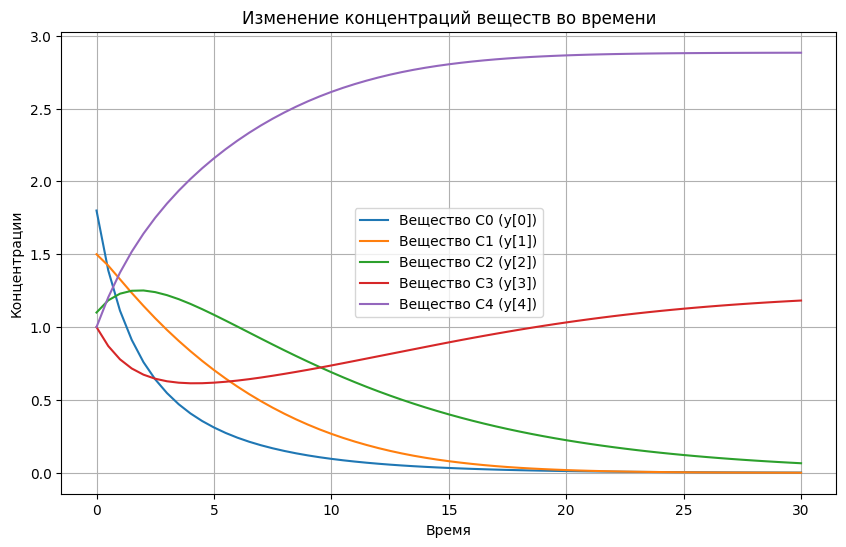

Начальные концентрации:        [1.8 1.5 1.1 1.  1. ]
Сумма концентраций веществ:    6.4
Концентрации после 30 секунд:  [0.03691376 0.09092314 0.42450336 0.87948027 2.79241878]
Сумма концентрций веществ:     4.224239303628252


In [6]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", INIT_CONC)
print("Сумма концентраций веществ:   ", sum(INIT_CONC))
print(f"Концентрации после {VR_TIME} секунд:  {sol.y[:, VR_TIME - 1]}")
print("Сумма концентрций веществ:    ", sum(sol.y[:, VR_TIME - 1]))

# Сохранение промежуточных результатов. Понадобятся в будущем
true_values = sol.y.copy()

### Вычисление приращений концентраций со временем

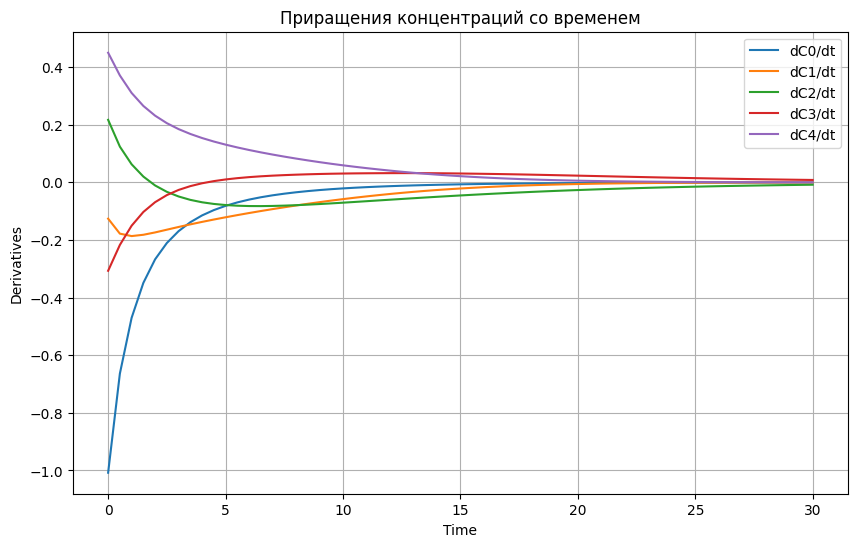

In [7]:
dydt_eval = np.array([true_ode_func(t, y, k) for t, y in zip(sol.t, sol.y.T)]).T      # прямая задача

plt.figure(figsize=(10, 6))
for i in range(dydt_eval.shape[0]):
    plt.plot(sol.t, dydt_eval[i], label=f'dС{i}/dt')

plt.title('Приращения концентраций со временем')
plt.xlabel('Time')
plt.ylabel('Derivatives')
plt.legend()
plt.grid()
plt.show()

In [8]:
print(dydt_eval[0])   # массив приращений в моменты времени tsteps

[-1.00800002e+00 -6.63956225e-01 -4.70238209e-01 -3.48970979e-01
 -2.67218441e-01 -2.10570961e-01 -1.69413432e-01 -1.38419956e-01
 -1.14749715e-01 -9.63259488e-02 -8.16445351e-02 -6.96786121e-02
 -5.98701015e-02 -5.17726354e-02 -4.50266078e-02 -3.93453278e-02
 -3.45014334e-02 -3.03388946e-02 -2.67574750e-02 -2.36675031e-02
 -2.09919158e-02 -1.86644457e-02 -1.66281201e-02 -1.48340715e-02
 -1.32454569e-02 -1.18406191e-02 -1.05978735e-02 -9.49759595e-03
 -8.52206722e-03 -7.65527645e-03 -6.88277418e-03 -6.19152794e-03
 -5.57062263e-03 -5.01412805e-03 -4.51554684e-03 -4.06867871e-03
 -3.66786937e-03 -3.30798118e-03 -2.98436754e-03 -2.69288593e-03
 -2.43029790e-03 -2.19383952e-03 -1.98092568e-03 -1.78916752e-03
 -1.61636539e-03 -1.46050344e-03 -1.31975068e-03 -1.19262154e-03
 -1.07786048e-03 -9.74281284e-04 -8.80785636e-04 -7.96361011e-04
 -7.20079348e-04 -6.51106995e-04 -5.88759314e-04 -5.32420003e-04
 -4.81515162e-04 -4.35513852e-04 -3.93927709e-04 -3.56312870e-04
 -3.22296139e-04]


# Добавление шума

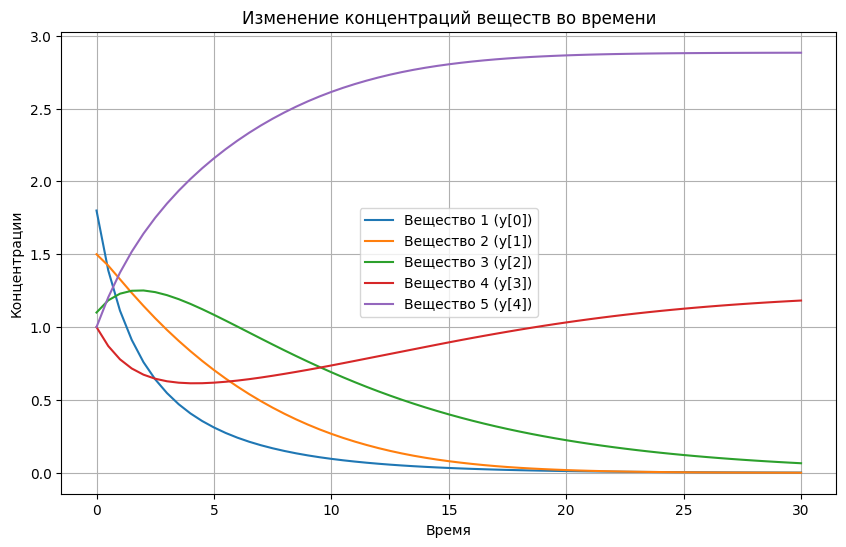

In [9]:
# Генерация шума
noise_level = 5e-2  # Уровень шума

# Создание копии, чтобы работать с ней
y_noisy = sol.y.copy()

# Генерация шума и его добавление
# noise = np.random.normal(0, noise_level * np.abs(y_noisy))
# y_noisy += noise

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, y_noisy[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


# Построение полиномиальных аппроксимаций функций изменения концентраций

Вещество C0: R^2 = 0.999835
Свободный коэффициент: 1.786643
Коэффициенты полинома, начиная с x^1:
-0.8739920238, 0.2530155419, -0.0464345586, 0.0053952533, -0.0003987328, 0.0000186257, -0.0000005314, 0.0000000084, -0.0000000001

Вещество C1: R^2 = 0.999990
Свободный коэффициент: 1.504296
Коэффициенты полинома, начиная с x^1:
-0.1725539769, -0.0103630604, 0.0050071103, -0.0007199038, 0.0000596208, -0.0000030161, 0.0000000913, -0.0000000015, 0.0000000000

Вещество C2: R^2 = 0.999996
Свободный коэффициент: 1.102256
Коэффициенты полинома, начиная с x^1:
0.1950689389, -0.0826071105, 0.0138066644, -0.0014508017, 0.0001001771, -0.0000044777, 0.0000001240, -0.0000000019, 0.0000000000

Вещество C3: R^2 = 0.999982
Свободный коэффициент: 0.998361
Коэффициенты полинома, начиная с x^1:
-0.2940046989, 0.0908780741, -0.0155042167, 0.0016874702, -0.0001181609, 0.0000052782, -0.0000001452, 0.0000000022, -0.0000000000

Вещество C4: R^2 = 0.999998
Свободный коэффициент: 1.001375
Коэффициенты полинома, на

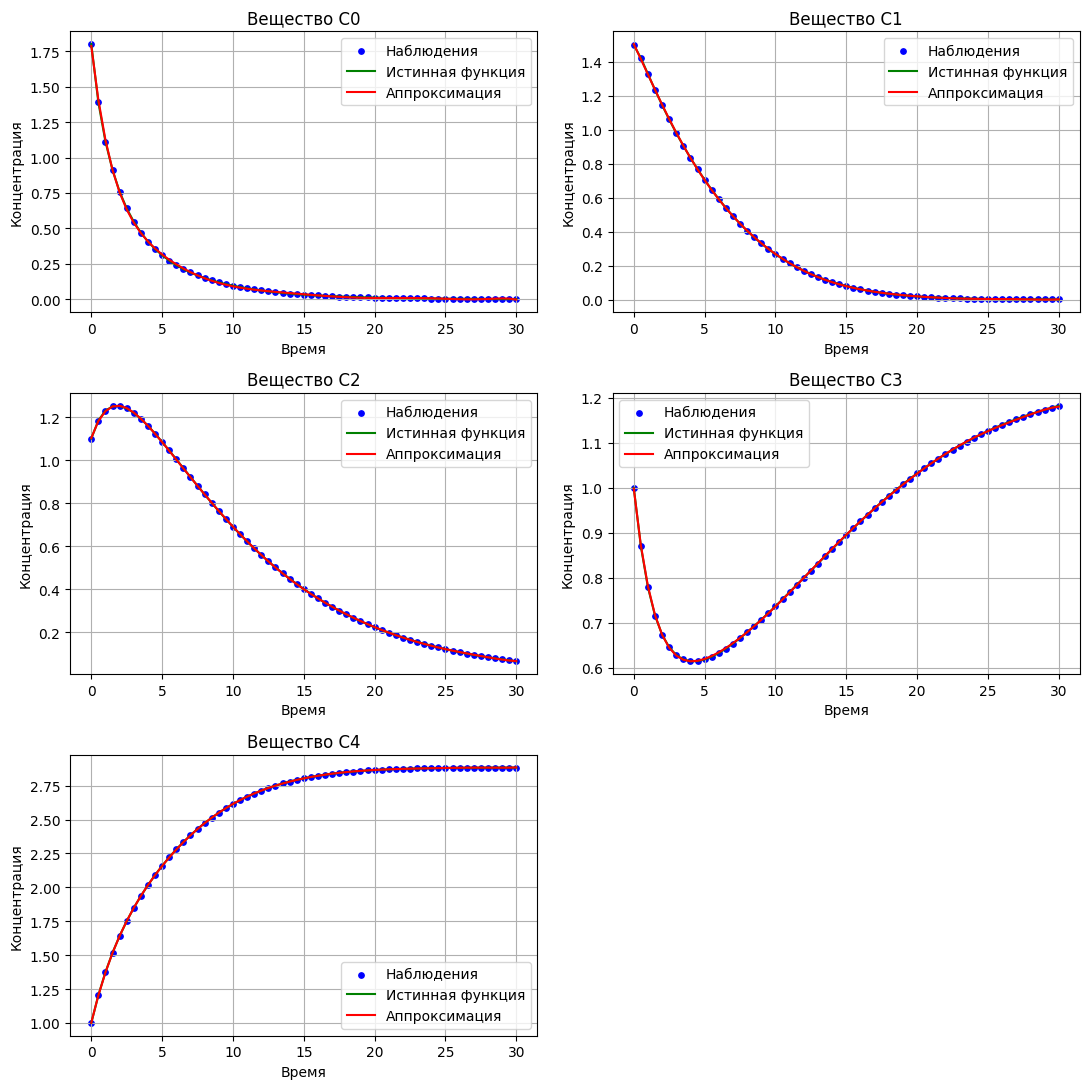

In [10]:
# Преобразование признаков в полиномиальные
poly_degree = 9
poly = PolynomialFeatures(degree=poly_degree)
time_vec = sol.t.reshape(-1, 1)         # Изменение формата временного шага для метода из sklearn
t_poly = poly.fit_transform(time_vec)

# Определяем количество строк и столбцов для сетки графиков
rows, cols = (3, 2)  # Подходит для N_SUBSTANCE = 6
fig, axes = plt.subplots(rows, cols, figsize=(11, 11), squeeze=False)   # Размер общего окна

# Массив для коэффициентов полиномов
reaction_poly_coeffs = np.zeros((N_SUBSTANCE, poly_degree + 1))  # Массив из 5 строк и 9 столбцов. Тут будут храниться коэффициенты полиномов 
                                                   # Столбцы - число коэффициентов полинома, строки - концентрации веществ

# Перебираем вещества
for i in range(N_SUBSTANCE):
    y = y_noisy[i].flatten()  # Преобразование в 1D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # Определяем текущую ось
    ax = axes[i // cols, i % cols]
    
    # Строим график
    ax.scatter(time_vec, y, color='blue', label='Наблюдения', s=15)
    ax.plot(sol.t, true_values[i], color='green', label='Истинная функция')
    ax.plot(time_vec, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    ax.set_title(f'Вещество C{i}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Концентрация')
    ax.legend()
    ax.grid()

    # Сохранение коэффициентов полинома
    reaction_poly_coeffs[i, 0] = model.intercept_
    reaction_poly_coeffs[i, 1:] = model.coef_[1:]  # Пропускаем свободный член
    
    # Вывод коэффициентов
    r2 = model.score(t_poly, y)
    print(f"Вещество C{i}: R^2 = {r2:.6f}")
    print(f"Свободный коэффициент: {model.intercept_:.6f}")
    print("Коэффициенты полинома, начиная с x^1:")
    print(f"{', '.join(f'{coef:.10f}' for coef in model.coef_[1:])}\n")

# Убираем пустые графики
for j in range(N_SUBSTANCE, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()


Здесь первый элемент `model.coef_[0]` = `0.00000000e+00` соответствует \(x^0\). Он, равен `0`, так как свободный член отдельно хранится в `model.intercept_`.

### Визуализация полиномов в более презентабельном виде

In [11]:
# Функция для форматирования полинома
def format_polynomial(coefficients):
    terms = []
    for power, coef in enumerate(coefficients):
        if abs(coef) > 1e-10:  # Пропускать практически нулевые коэффициенты
            term = f"{coef:.5e}" if power == 0 else f"{coef:.5e}*t^{power}"
            terms.append(term)
    return " + ".join(terms).replace("+ -", "- ")  # Убираем лишние плюсы перед отрицательными числами

# Генерация и вывод полиномов
for i, coeffs in enumerate(reaction_poly_coeffs):
    print(f"C{i}(t) = ", end='')
    print(format_polynomial(coeffs))


C0(t) = 1.78664e+00 - 8.73992e-01*t^1 + 2.53016e-01*t^2 - 4.64346e-02*t^3 + 5.39525e-03*t^4 - 3.98733e-04*t^5 + 1.86257e-05*t^6 - 5.31368e-07*t^7 + 8.43858e-09*t^8
C1(t) = 1.50430e+00 - 1.72554e-01*t^1 - 1.03631e-02*t^2 + 5.00711e-03*t^3 - 7.19904e-04*t^4 + 5.96208e-05*t^5 - 3.01613e-06*t^6 + 9.13074e-08*t^7 - 1.51680e-09*t^8
C2(t) = 1.10226e+00 + 1.95069e-01*t^1 - 8.26071e-02*t^2 + 1.38067e-02*t^3 - 1.45080e-03*t^4 + 1.00177e-04*t^5 - 4.47774e-06*t^6 + 1.24019e-07*t^7 - 1.92889e-09*t^8
C3(t) = 9.98361e-01 - 2.94005e-01*t^1 + 9.08781e-02*t^2 - 1.55042e-02*t^3 + 1.68747e-03*t^4 - 1.18161e-04*t^5 + 5.27820e-06*t^6 - 1.45153e-07*t^7 + 2.23721e-09*t^8
C4(t) = 1.00138e+00 + 4.39345e-01*t^1 - 8.01868e-02*t^2 + 1.27060e-02*t^3 - 1.39737e-03*t^4 + 9.91583e-05*t^5 - 4.46462e-06*t^6 + 1.23296e-07*t^7 - 1.90443e-09*t^8


Нахождение производных от функций концентраций веществ

Так как в нашем случае в качестве функций используются только полиномы, то я напишу функцию вручную

`print(reaction_poly_coeffs)` - чтобы посмотреть массив с коэффициентами полиномов для каждого вещества

In [12]:
def differentiate_polynomial(coefficients):
    degree = len(coefficients) # степень полинома + 1
    return np.array([coefficients[i] * i for i in range(1, degree)])

reaction_poly_derivatives = np.array([differentiate_polynomial(coeff) for coeff in reaction_poly_coeffs])

print(reaction_poly_derivatives)

[[-8.73992024e-01  5.06031084e-01 -1.39303676e-01  2.15810131e-02
  -1.99366413e-03  1.11753925e-04 -3.71957390e-06  6.75086075e-08
  -5.14008835e-10]
 [-1.72553977e-01 -2.07261208e-02  1.50213308e-02 -2.87961513e-03
   2.98104145e-04 -1.80967938e-05  6.39151580e-07 -1.21343658e-08
   9.56482393e-11]
 [ 1.95068939e-01 -1.65214221e-01  4.14199932e-02 -5.80320664e-03
   5.00885556e-04 -2.68664286e-05  8.68133839e-07 -1.54311118e-08
   1.15702448e-10]
 [-2.94004699e-01  1.81756148e-01 -4.65126502e-02  6.74988071e-03
  -5.90804435e-04  3.16692062e-05 -1.01607341e-06  1.78976647e-08
  -1.32991618e-10]
 [ 4.39345247e-01 -1.60373585e-01  3.81178876e-02 -5.58948502e-03
   4.95791500e-04 -2.67877005e-05  8.63069930e-07 -1.52354728e-08
   1.13333842e-10]]


### Визуализация различий между приращениями в обратной и прямой задачах

### Оригинал (прямая задача)

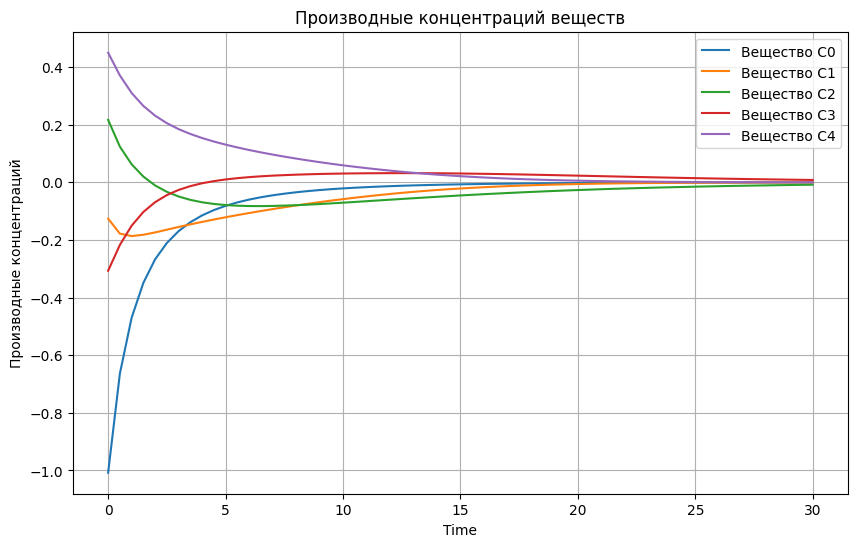

In [13]:
# Диапазон значений x
# x = np.linspace(0, 30, 61)    # Базово использовать tsteps

# Построение графиков
plt.figure(figsize=(10, 6))

for i in range(N_SUBSTANCE):
    plt.plot(tsteps, dydt_eval[i], label=f'Вещество C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные концентраций веществ')
plt.legend()
plt.grid()
plt.show()


### Пародия (обратная задача)

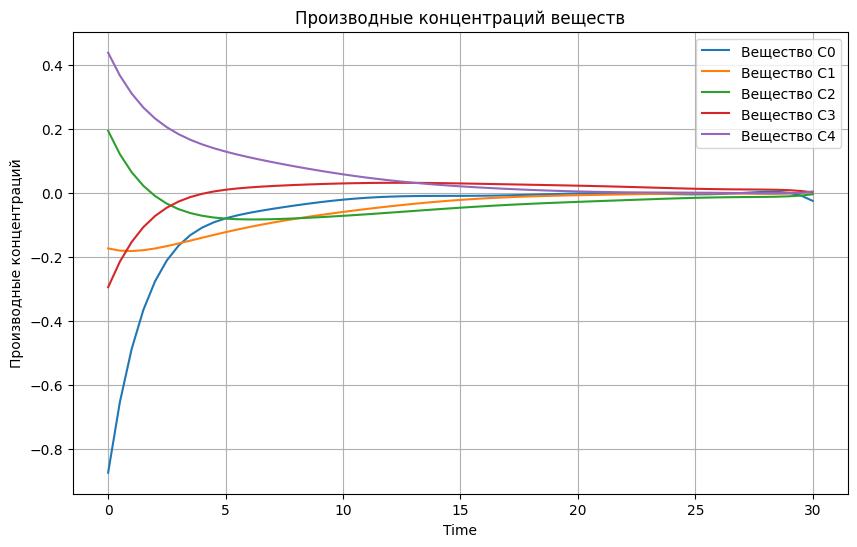

In [14]:
dydt_pred = np.zeros_like(dydt_eval)         # Приращения в обратной задаче

# Построение графиков
plt.figure(figsize=(10, 6))

for i, coeffs in enumerate(reaction_poly_derivatives):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    dydt_pred[i, :] = y

    # Вывод на график
    plt.plot(tsteps, dydt_pred[i], label=f'Вещество C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные концентраций веществ')
plt.legend()
plt.grid()
plt.show()

### Различие между приращениями

### Визуализация в plotly

In [15]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(N_SUBSTANCE):
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dydt_eval[i] - dydt_pred[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные концентраций веществ',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1000,  # Ширина холста
    height=600   # Высота холста
)

fig.show()

## Частотное что-то там

In [16]:
fig = go.Figure()

# Дискретизация по времени (шаг)
dt = tsteps[1] - tsteps[0]  # Предполагаем, что шаг одинаковый

# Добавляем спектры для каждого вещества
for i, coeffs in enumerate(reaction_poly_derivatives):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    signal = dydt_eval[i] - y  # Исходный сигнал (разность производных)

    # Применяем БПФ (FFT)
    fft_values = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=dt)  # Вычисляем частоты

    # Берём только положительные частоты и нормируем амплитуды
    mask = freqs > 0
    freqs, fft_values = freqs[mask], np.abs(fft_values[mask])  

    # Добавляем в график
    fig.add_trace(go.Scatter(
        x=freqs, 
        y=fft_values, 
        mode='lines', 
        name=f'Частоты C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Частотный спектр производных концентраций',
    xaxis_title='Frequency (Hz)',
    yaxis_title='Amplitude',
    legend_title='Вещества',
    template='plotly_white',
    width=1000,
    height=600
)

fig.show()


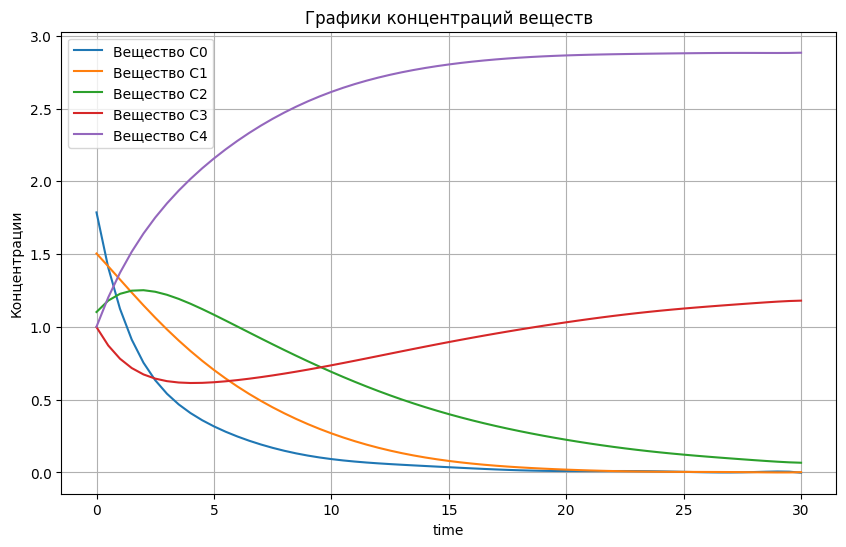

In [17]:
# Диапазон значений x
# t = np.linspace(0, 30, 100)       # Базово использовать tsteps

# Построение графиков
plt.figure(figsize=(10, 6))
for i, coeffs in enumerate(reaction_poly_coeffs):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    plt.plot(tsteps, y, label=f'Вещество C{i}')

plt.xlabel('time')
plt.ylabel('Концентрации')
plt.title('Графики концентраций веществ')
plt.legend()
plt.grid()
plt.show()


# Проверяем концентрации

Статистика по ошибкам

In [18]:
# шаг по времени
# t = np.linspace(0, 30, 31)
error_matrix = np.zeros_like(y_noisy)  # пустая матрица той же размерности

for i, coeffs in enumerate(reaction_poly_coeffs):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    # error_matrix[i] = y_noisy[i] - y  # Заполняем матрицу ошибками
    error_matrix[i] = abs(y_noisy[i] - y)  # Заполняем матрицу ошибками

# Вычисляем статистики по всей матрице
max_value = np.max(error_matrix)
min_value = np.min(error_matrix)
mean_value = np.mean(error_matrix)
median_value = np.median(error_matrix)

# Вычисляем статистики по каждой строке
max_per_row = np.max(error_matrix, axis=1)
min_per_row = np.min(error_matrix, axis=1)
mean_per_row = np.mean(error_matrix, axis=1)
median_per_row = np.median(error_matrix, axis=1)

# Вывод общих статистик
print(f"Максимальное значение ошибки: {max_value:.6f}")
print(f"Минимальное значение ошибки: {min_value:.6f}")
print(f"Среднее значение ошибки: {mean_value:.6f}")
print(f"Медиана ошибки: {median_value:.6f}")

# Вывод статистик по каждой строке
# for i in range(error_matrix.shape[0]):
#     print(f"\nСтрока {i}:")
#     print(f"  Максимум: {max_per_row[i]:.6f}")
#     print(f"  Минимум: {min_per_row[i]:.6f}")
#     print(f"  Среднее: {mean_per_row[i]:.6f}")
#     print(f"  Медиана: {median_per_row[i]:.6f}")

Максимальное значение ошибки: 0.018035
Минимальное значение ошибки: 0.000002
Среднее значение ошибки: 0.001194
Медиана ошибки: 0.000637


### Вычисление k по приращениям из прямой задачи

In [19]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

# Определяем размерность будущей матрицы k_pred
k_pred = np.zeros((4, len(tsteps)))  # Делаем k_pred матрицей размерности (num_reactions, tsteps)

for i, val in enumerate(tsteps):
    dC = np.array([np.polyval(substance[::-1], val) for substance in reaction_poly_derivatives])
    W = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC
    C = np.array([np.polyval(substance[::-1], val) for substance in reaction_poly_coeffs])
    result = np.prod(C ** MATR_PLUS, axis=1)

    k_pred[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred
    print(dC)

# print(k_pred)  # Выводим матрицу


[-0.87399202 -0.17255398  0.19506894 -0.2940047   0.43934525]
[-0.65322594 -0.17950358  0.12212191 -0.213947    0.3680194 ]
[-0.48756917 -0.18085775  0.06594638 -0.15257145  0.31196992]
[-0.36482827 -0.17818506  0.02319811 -0.10600482  0.2680017 ]
[-0.2750485  -0.17272787 -0.00889713 -0.07104619  0.23348252]
[-0.21019067 -0.16545374 -0.03262189 -0.04507445  0.20626483]
[-0.16384239 -0.15710102 -0.0498373  -0.02596532  0.18461569]
[-0.13096108 -0.14821911 -0.06204583 -0.012017    0.16715404]
[-0.10764666 -0.13920357 -0.07044716 -0.00188413  0.15279503]
[-0.09094154 -0.13032682 -0.07598751  0.00548071  0.14070066]
[-0.07865594 -0.12176448 -0.07940305  0.01087853  0.13023647]
[-0.06921627 -0.11361793 -0.08125784  0.01490891  0.12093368]
[-0.06153489 -0.10593329 -0.08197667  0.01800912  0.11245634]
[-0.05489904 -0.09871737 -0.08187335  0.02048771  0.10457314]
[-0.04887746 -0.0919506  -0.08117477  0.02255327  0.09713338]
[-0.04324263 -0.08559752 -0.08004118  0.02433856  0.09004677]
[-0.0379

In [30]:
print(dydt_pred.T[0])

[-0.87399202 -0.17255398  0.19506894 -0.2940047   0.43934525]


In [20]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(k_pred.shape[0]):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_pred[i, :], 
        mode='lines', 
        name=f'Реакция {i}'
    ))

# Настройки графика
fig.update_layout(
    title='Изменение коэффициентов во времени',
    xaxis_title='Время, t',
    yaxis_title='Коэффициент k',
    legend_title='Вещества',
    template='plotly_white',
    width=1000,  
    height=600
)

# Ограничение оси Y (аналог plt.ylim)
fig.update_yaxes(range=[-2, 2])  

# Отображение графика
fig.show()



### Сохранение предсказанных констант k

In [21]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

# Определяем размерность будущей матрицы k_pred
k_pred = np.zeros((4, len(tsteps)))  # Делаем k_pred матрицей размерности (num_reactions, tsteps)

for i, val in enumerate(tsteps):
    dC = np.array([np.polyval(substance[::-1], val) for substance in reaction_poly_derivatives])
    W = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC
    C = np.array([np.polyval(substance[::-1], val) for substance in reaction_poly_coeffs])
    result = np.prod(C ** MATR_PLUS, axis=1)

    k_pred[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

# print(k_pred)  # Выводим матрицу


In [22]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(k_pred.shape[0]):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_pred[i, :], 
        mode='lines', 
        name=f'Реакция {i}'
    ))

# Настройки графика
fig.update_layout(
    title='Изменение коэффициентов во времени',
    xaxis_title='Время, t',
    yaxis_title='Коэффициент k',
    legend_title='Вещества',
    template='plotly_white',
    width=1000,  
    height=600
)

# Ограничение оси Y (аналог plt.ylim)
fig.update_yaxes(range=[-2, 2])  

# Отображение графика
fig.show()


In [23]:
print(np.linalg.inv(MATR @ MATR.T) @ MATR)

[[-0.3125  0.375  -0.3125 -0.3125  0.0625]
 [-0.3125 -0.625   0.6875  0.6875  0.0625]
 [-0.25   -0.5    -0.25    0.75    0.25  ]
 [-0.1875 -0.375  -0.1875 -0.1875  0.4375]]


In [24]:
# Точка в которой считаем значения
t_1 = 0.5
t_2 = 6
t_3 = 15

# Вычисление значения полиномов в точке t
dC_1 = np.array([np.polyval(substance[::-1], t_1) for substance in reaction_poly_derivatives])
dC_2 = np.array([np.polyval(substance[::-1], t_2) for substance in reaction_poly_derivatives])
dC_3 = np.array([np.polyval(substance[::-1], t_3) for substance in reaction_poly_derivatives])

print('Производные концентраций в моменты времени:')
print('dC(t=0.5) = ', dC_1)
print('dC(t=6)   = ', dC_2)
print('dC(t=12)  = ', dC_3)

# Вычисление значения скоростей реакций в моменты времени
W_1 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_1  # t_1 = 0.5
W_2 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_2  # t_2 = 6
W_3 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_3  # t_3 = 12

print()
print('Вектора скоростей реакций в моменты времени:')
print('W(t=0.5) = ', W_1)
print('W(t=6)   = ', W_2)
print('W(t=12)  = ', W_3)

# Вычисление концентраций веществ в моменты времени
C_1 = np.array([np.polyval(substance[::-1], t_1) for substance in reaction_poly_coeffs])
C_2 = np.array([np.polyval(substance[::-1], t_2) for substance in reaction_poly_coeffs])
C_3 = np.array([np.polyval(substance[::-1], t_3) for substance in reaction_poly_coeffs])

print()
print('Концентрации в моменты времени:')
print('C(t=0.5) = ', C_1)
print('C(t=6)   = ', C_2)
print('C(t=12)  = ', C_3)

Производные концентраций в моменты времени:
dC(t=0.5) =  [-0.65322594 -0.17950358  0.12212191 -0.213947    0.3680194 ]
dC(t=6)   =  [-0.06153489 -0.10593329 -0.08197667  0.01800912  0.11245634]
dC(t=12)  =  [-0.00818414 -0.02087612 -0.0452616   0.03059725  0.02153366]

Вектора скоростей реакций в моменты времени:
W(t=0.5) =  [0.18851582 0.2761943  0.1540724  0.3680194 ]
W(t=6)   =  [0.00652305 0.04848879 0.13046546 0.11245634]
W(t=12)  =  [0.00065746 0.00686922 0.05213084 0.02153361]

Концентрации в моменты времени:
C(t=0.5) =  [1.40742184 1.41601132 1.18077716 0.87224228 1.20250501]
C(t=6)   =  [0.24693536 0.59045342 1.00248552 0.63441007 2.27841373]
C(t=12)  =  [0.03583904 0.0789996  0.40062624 0.89572721 2.80326256]


In [25]:
# Вычисление вектора с использованием заданной формулы
result_1 = np.prod(C_1 ** MATR_PLUS, axis=1)
result_2 = np.prod(C_2 ** MATR_PLUS, axis=1)
result_3 = np.prod(C_3 ** MATR_PLUS, axis=1)

In [26]:
print(f'k(t={t_1}) = {W_1/result_1}')
print(f'k(t={t_2}) = {W_2/result_2}')
print(f'k(t={t_3}) = {W_3/result_3}')
print()
print('Истинные значения:' ,k)

k(t=0.5) = [0.09516982 0.19624131 0.13048389 0.2979661 ]
k(t=6) = [0.1069754  0.19636229 0.13014199 0.30021213]
k(t=15) = [0.51186903 0.19166873 0.13012338 0.30430996]

Истинные значения: tensor([0.1000, 0.2000, 0.1300, 0.3000])


In [27]:
print(dydt_eval.shape)
print(dydt_pred.shape)

(5, 61)
(5, 61)


In [28]:
print(dydt_eval[:, 5] - dydt_pred[:, 5])

[-0.00038029  0.00112734 -0.00030229  0.00081476 -0.00079563]
